![](https://uploads-ssl.webflow.com/62233c592d2a1e009d42f46c/6414802c0a2bea367cbc795b_logo-jedha-square.svg)

<h1 style="text-align: left; color:#20a08d; font-size: 40px"><span><strong>Atari RLlib Solutions

</strong></span></h1>

<h2 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>Installation environnement

</strong></span></h2>

In [1]:
!mkdir atari

In [25]:
%%writefile atari/requirements.txt
ray[rllib]==2.0.1
tensorflow
gym[atari]
gym[accept-rom-license]
gym[toy_text]
atari_py
pyglet
numpy==1.23.5

Overwriting atari/requirements.txt


In [27]:
!pip3 install -r atari/requirements.txt

  Using cached numpy-1.23.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.


<h2 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>Test environnement
</strong></span></h2>

In [23]:
!mkdir atari/assets
!mkdir atari/checkpoints
!mkdir /root/ray_results/PPO_ALE

mkdir: cannot create directory ‘atari/assets’: File exists
mkdir: cannot create directory ‘atari/checkpoints’: File exists


In [1]:
%%writefile atari/test_env.py
import gym
from PIL import Image
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

env = gym.make("ALE/Assault-v5")
print(env.action_space)
env.action_space.seed(42)
arr = []

observation = env.reset()

for _ in range(1000):
    observation, reward, done, info = env.step(env.action_space.sample())
    render_img = env.render(mode="rgb_array")
    arr.append(render_img)

    if done:
        observation = env.reset()

env.close()
imgs = [Image.fromarray(img) for img in arr]
save_path = os.path.join(os.getcwd(),"atari", "assets","random_atari.gif")
imgs[0].save(save_path, save_all=True, append_images=imgs[1:], duration=50, loop=0)

Overwriting atari/test_env.py


A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]
Discrete(7)


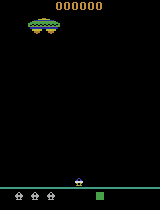

In [2]:
!python3 atari/test_env.py
from IPython.display import Image
Image(open('atari/assets/random_atari.gif','rb').read())

<h2 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>Fichier de configuration
</strong></span></h2>

In [3]:
%%writefile atari/config.py
# Configure the algorithm.
config = {
    # Environment (RLlib understands openAI gym registered strings).
    "env": "ALE/Assault-v5",

    # Use 2 environment workers (aka "rollout workers") that parallelly
    # collect samples from their own environment clone(s).
    "num_workers": 0,
    # Change this to "framework: torch", if you are using PyTorch.
    # Also, use "framework: tf2" for tf2.x eager execution.
    "framework": "tf",
    # Tweak the default model provided automatically by RLlib,
    # given the environment's observation- and action spaces.
    "render_env": False,

    "train_batch_size": 256,

    "preprocessor_pref": "rllib",

    "model": {
        "fcnet_hiddens": [16, 16],
        "fcnet_activation": "relu",
    },
}

Overwriting atari/config.py


<h2 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>Entrainement de l'agent
</strong></span></h2>

**SOLUTION 1 : Avec des couches fully-connected**

In [6]:
%%writefile atari/train.py
# Import the RL algorithm (Trainer) we would like to use.
from ray.rllib.algorithms.ppo import PPO
import gym
from config import config
import ray
import os
from ray.tune.logger import pretty_print
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Create our RLlib Trainer.
trainer = PPO(config=config)

# Run it for n training iterations. A training iteration includes
# parallel sample collection by the environment workers as well as
# loss calculation on the collected batch and a model update.
for i in range(1, 200):
    print(f"#### ITERATION {i} ####")
    result = trainer.train()
    print(pretty_print(result))

    if i % 10 == 0:
       checkpoint = trainer.save("/atari/checkpoints")
       print("checkpoint saved at", checkpoint)

Overwriting atari/train.py


In [7]:
!python3 atari/train.py

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:18: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Imp

**SOLUTION 2 : Avec des couches convolutives**

In [10]:
%%writefile atari/config.py
# Configure the algorithm.
config = {
    # Environment (RLlib understands openAI gym registered strings).
    "env": "ALE/Assault-v5",

    # Use 2 environment workers (aka "rollout workers") that parallelly
    # collect samples from their own environment clone(s).
    "num_workers": 0,
    # Change this to "framework: torch", if you are using PyTorch.
    # Also, use "framework: tf2" for tf2.x eager execution.
    "framework": "tf",
    # Tweak the default model provided automatically by RLlib,
    # given the environment's observation- and action spaces.
    "render_env": False,

    "train_batch_size": 256,

    "preprocessor_pref": "rllib",

    "model": {
          "dim": 15,
           "conv_filters": [
             [16, [15, 15], 1],
             [32, [15, 15], 1],            ],
},
}

Overwriting atari/config.py


In [11]:
!python3 atari/train.py

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
num_faulty_episodes: 0
num_healthy_workers: 0
num_recreated_workers: 0
num_steps_trained_this_iter: 256
perf:
  cpu_util_percent: 98.672972972973
  ram_util_percent: 17.262162162162156
pid: 10428
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_action_processing_ms: 0.13564573396925664
  mean_env_render_ms: 0.0
  mean_env_wait_ms: 0.8467038630942112
  mean_inference_ms: 3.2698594278859487
  mean_raw_obs_processing_ms: 1.125370558742652
sampler_results:
  custom_metrics: {}
  episode_len_mean: 593.5
  episode_media: {}
  episode_reward_max: 588.0
  episode_reward_mean: 344.27272727272725
  episode_reward_min: 63.0
  episodes_this_iter: 0
  hist_stats:
    episode_lengths: [527, 392, 552, 688, 448, 696, 696, 640, 776, 546, 568, 600,
      656, 608, 807, 641, 759, 711, 503, 482, 712, 544, 672, 719, 664, 640, 600, 408,
      610, 536, 616, 584, 632, 504, 580, 328, 536, 495, 

<h2 style="text-align: left; color:#20a08d; font-size: 20px"><span><strong>Test de l'agent
</strong></span></h2>

In [ ]:
%%writefile atari/config.py
# Import the RL algorithm (Trainer) we would like to use.
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.models.preprocessors import get_preprocessor
import gym
import time
from config import config
import glob
import os


# Create our RLlib Trainer.
trainer = PPO(config=config)

trainer.restore("./checkpoints/atari/checkpoint_000010/checkpoint-10")

# Create the env to do inference in.
env = gym.make("Assault-v4", render_mode="human")

obs = env.reset()

episode_reward = 0.0

done=False
while not done:

    print("### COMPUTING ACTION ####")
    # Compute an action (`a`).
    a = trainer.compute_single_action(obs, explore=True)

    # Send the computed action `a` to the env.
    obs, reward, done, _ = env.step(a)
    episode_reward += reward
    # Is the episode `done`? -> Reset
    # env.render() - No need to use it here since we are setting it directly in gym.make()
    # It works only with Atari games though
    if done:
        print(f"Episode done: Total reward = {episode_reward}")
        env.reset()
env.render()